### Compare three methods(SGD, HMC, Gibbs) and 2 models(narrow, wider).

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [2]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [3]:
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10, lr=1e-3):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    def call(self, x):
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y, is_gibbs = False, is_hmc = False, is_loss = False):
        
        # get current state
        if is_hmc:
            h_current = tf.split(h, self.hidden_layer_sizes, axis = 1)
        else:    
            h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h]
        h_current = convert2_zero_one(h_current)
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        if not is_loss:
            for i, (cv, pv, layer) in enumerate(zip(h_current, h_previous, self.fc_layers)):
            
                logits = layer(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(labels = cv, logits = logits)
                if not is_gibbs:
                    ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def gibbs_new_state(self, x, h, y):
        
        '''
            generate a new state for the network node by node in Gibbs setting.
        '''
        
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        
        in_layers = self.fc_layers
        out_layers = self.fc_layers[1:] + [self.output_layer]
        
        prev_vals = [x] + h_current[:-1]
        curr_vals = h_current
        next_vals = h_current[1:] + [y]
        
        for i, (in_layer, out_layer, pv, cv, nv) in enumerate(zip(in_layers, out_layers, prev_vals, curr_vals, next_vals)):

            # node by node
            
            nodes = tf.transpose(cv)
            prob_parents = tm.sigmoid(in_layer(pv))
            
            out_layer_weights = out_layer.get_weights()[0]
            
            next_logits = out_layer(cv)
            
            new_layer = []
            
            for j, node in enumerate(nodes):
                
                # get info for current node (i, j)
                
                prob_parents_j = prob_parents[:, j]
                out_layer_weights_j = out_layer_weights[j]
                
                # calculate logits and logprob for node is 0 or 1
                next_logits_if_node_0 = next_logits[:, :] - node[:, None] * out_layer_weights_j[None, :]
                next_logits_if_node_1 = next_logits[:, :] + (1 - node[:, None]) * out_layer_weights_j[None, :]
                
                #print(next_logits_if_node_0, next_logits_if_node_1)
                
                logprob_children_if_node_0 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_0), axis = -1)
                
                logprob_children_if_node_1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_1), axis = -1)
                
                # calculate prob for node (i, j)
                prob_0 = (1 - prob_parents_j) * tm.exp(logprob_children_if_node_0)
                prob_1 = prob_parents_j * tm.exp(logprob_children_if_node_1)
                prob_j = prob_1 / (prob_1 + prob_0)
            
                # sample new state with prob_j for node (i, j)
                new_node = tfp.distributions.Bernoulli(probs = prob_j).sample() # MAY BE SLOW
                
                # update nodes and logits for following calculation
                new_node_casted = tf.cast(new_node, dtype = "float32")
                next_logits = next_logits_if_node_0 * (1 - new_node_casted)[:, None] \
                            + next_logits_if_node_1 * new_node_casted[:, None] 
                
                # keep track of new node values (in prev/curr/next_vals and h_new)
                new_layer.append(new_node)
           
            new_layer = tf.transpose(new_layer)
            h_current[i] = new_layer
            prev_vals = [x] + h_current[:-1]
            curr_vals = h_current
            next_vals = h_current[1:] + [y]
        
        return h_current
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob(x, v, y, is_hmc = True),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y, is_gibbs = False):
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y, is_gibbs = is_gibbs))
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [4]:
def standard_backprop(size, data, epochs):
    '''
    Standard Backpropogation training
    '''
    
    batch_size = 4
    
    print("Start Standard Backprop")
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(2,)),
            layers.Dense(size, activation = "sigmoid"),
            layers.Dense(1, activation = "sigmoid")
        ]
    )   
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    st = time.time()
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    history = model.fit(data, batch_size=batch_size, epochs=epochs)
    train_time = time.time() - st
    
    return train_time, history

In [5]:
def hmc(size, data, epochs):
    '''
    HMC training
    '''
    
    print("Start HMC")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs=1, lr = 0.01)
    network = [model.call(images) for images, labels in data]
    kernels = [model.generate_hmc_kernel(images, labels) for images, labels in data]
    
    print("Start HMC Burning")
    burnin = 1000
    tlp = []
    for i in range(burnin):
        
        if(i % 100 == 0): print("Step %d" % i)
        #network, kernels = zip(*[model.propose_new_state_hamiltonian(x, net, y, ker) 
        #           for (x, y), net, ker in zip(data, network, kernels)])
        res = []
        loss = 0.0
        for (x, y), net, ker in zip(train_ds, network, kernels):
            res.append(model.propose_new_state_hamiltonian(x, net, y, ker))
            loss += -1 * tf.reduce_sum(model.target_log_prob(x, net, y))
    
        network, kernels = zip(*res)
        tlp.append(loss / 4)
        
    
    print("Start HMC Training")
    loss_ls = []
    acc_ls = []
    start_time = time.time()
    
    for epoch in range(epochs):
    
        loss = 0.0
        acc = 0.0
        for bs, (x, y) in enumerate(data):
        
            # only one mini-batch
            model.update_weights(x, network[bs], y)
            res = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                       for (x, y), net, ker in zip(data, network, kernels)]
            network = res
            loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y, is_loss = True))
    
        preds = [model.get_predictions(images) for images, labels in data]
        train_acc = accuracy_score(np.concatenate(preds), y_train)
        loss_ls.append(loss / 4)
        acc_ls.append(train_acc)
    
        print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss_ls[epoch], train_acc))

    train_time = time.time() - start_time
    return tlp, train_time, {"acc": acc_ls, "loss": loss_ls}

In [6]:
def gibbs(size, data, epochs):
    '''
    Gibbs Training
    '''
    
    print("Start Gibbs")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs=1, lr = 0.01)
    network = [model.call(images) for images, labels in data]
    burnin = 1000
    tlp = []
    for i in range(burnin):
    
        if(i % 100 == 0): print("Step %d" % i)
        network_new = []
        loss = 0.0
        for (x, y), net in zip(train_ds, network):
            network_new.append(model.gibbs_new_state(x, net, y))
            loss += -1 * tf.reduce_sum(model.target_log_prob(x, net, y, is_gibbs = True))
        
        network = network_new
        tlp.append(loss / 4)
    
    # Training
    loss_ls = []
    acc_ls = []
    start_time = time.time()

    for epoch in range(epochs):
    
        loss = 0.0
        acc = 0.0
        for bs, (x, y) in enumerate(train_ds):
        
            model.update_weights(x, network[bs], y, is_gibbs = True)
            network = [model.gibbs_new_state(x, net, y) for (x, y), net in zip(train_ds, network)]
            loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y, is_gibbs = True, is_loss = True))
    
        preds = [model.get_predictions(images) for images, labels in train_ds]
        train_acc = accuracy_score(np.concatenate(preds), y_train)
        loss_ls.append(loss / 4)
        acc_ls.append(train_acc)
    
        print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
              % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss_ls[epoch], train_acc))

    train_time = time.time() - start_time
    return tlp, train_time, {"acc": acc_ls, "loss": loss_ls}

In [7]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

2021-11-29 15:01:14.328715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model_size = [32]
for size in model_size:

    '''
    if size == 2:
        
        # set weights for size = 2
        w_0 = np.array([[1, -1], [1, -1]], dtype = "float32")
        b_0 = np.array([-0.5, 1], dtype = "float32")
        l_0 = [w_0, b_0]

        w_1 = np.array([[1], [1]], dtype = "float32")
        b_1 = np.array([-1], dtype = "float32")
        l_1 = [w_1, b_1]
        
        model_bp.layers[0].set_weights(l_0)
        model_bp.layers[1].set_weights(l_1)
        
        network = [model.call(images) for images, labels in train_ds] # initial the shape of the weights 
        model.fc_layers[0].set_weights(l_0)
        model.output_layer.set_weights(l_1)
    '''
    
    epochs = 1000
    time_bp, history_bp = standard_backprop(size, train_ds, epochs)
    tlp_burnin_hmc, time_hmc, history_hmc = hmc(size, train_ds, epochs)
    tlp_burnin_gibbs, time_gibbs, history_gibbs = gibbs(size, train_ds, epochs)
    

Start Standard Backprop
Epoch 1/1000
1/1 [==============================] - 0s 352ms/step - loss: 0.7208 - accuracy: 0.5000
Epoch 2/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7022 - accuracy: 0.5000
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7001 - accuracy: 0.5000
Epoch 6/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7025 - accuracy: 0.5000
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.7017 - accuracy: 0.5000
Epoch 8/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5000
Epoch 9/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6961 - accuracy: 0.5000
Epoch 10/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6942 - accuracy: 

2021-11-29 15:01:14.898232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 14/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6968 - accuracy: 0.5000
Epoch 15/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6967 - accuracy: 0.5000
Epoch 16/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.5000
Epoch 17/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.5000
Epoch 18/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.5000
Epoch 19/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5000
Epoch 20/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 21/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5000
Epoch 22/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6945 - accuracy: 0.5000
Epoch 23/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 24/1

1/1 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.7500
Epoch 97/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.7500
Epoch 98/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.7500
Epoch 99/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.7500
Epoch 100/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6812 - accuracy: 0.7500
Epoch 101/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6806 - accuracy: 0.7500
Epoch 102/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6800 - accuracy: 0.7500
Epoch 103/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.7500
Epoch 104/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6786 - accuracy: 0.7500
Epoch 105/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.6778 - accuracy: 0.7500
Epoch 106/1000
1/1

1/1 [==============================] - 0s 2ms/step - loss: 0.4924 - accuracy: 1.0000
Epoch 178/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4869 - accuracy: 1.0000
Epoch 179/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 1.0000
Epoch 180/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4758 - accuracy: 1.0000
Epoch 181/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 1.0000
Epoch 182/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4643 - accuracy: 1.0000
Epoch 183/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 1.0000
Epoch 184/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4524 - accuracy: 1.0000
Epoch 185/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 1.0000
Epoch 186/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 1.0000
Epoch 187/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0760 - accuracy: 1.0000
Epoch 260/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0741 - accuracy: 1.0000
Epoch 261/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0722 - accuracy: 1.0000
Epoch 262/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0704 - accuracy: 1.0000
Epoch 263/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0687 - accuracy: 1.0000
Epoch 264/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0670 - accuracy: 1.0000
Epoch 265/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0654 - accuracy: 1.0000
Epoch 266/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0638 - accuracy: 1.0000
Epoch 267/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0623 - accuracy: 1.0000
Epoch 268/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0608 - accuracy: 1.0000
Epoch 269/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 342/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 343/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 1.0000
Epoch 344/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 1.0000
Epoch 345/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 1.0000
Epoch 346/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 347/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0166 - accuracy: 1.0000
Epoch 348/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 349/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 1.0000
Epoch 350/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 351/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 424/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 425/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 426/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 1.0000
Epoch 427/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 428/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 1.0000
Epoch 429/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 430/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 1.0000
Epoch 431/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 432/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 433/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 506/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 507/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 508/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 509/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 510/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 511/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 512/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 513/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 514/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 515/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 588/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 589/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 590/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 591/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 592/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 593/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 594/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 595/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 596/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 597/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 671/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 672/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 673/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 674/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 675/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 676/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 677/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 678/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 679/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 752/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 753/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 754/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 755/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 756/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 757/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 758/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 759/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 760/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 761/1000


1/1 [==============================] - 0s 3ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 834/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 835/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 836/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 837/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 838/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 839/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 840/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 841/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 842/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 843/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 916/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 917/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 918/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 919/1000
1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 920/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 921/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 922/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 924/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 925/1000


1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 998/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 999/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 1000/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0010 - accuracy: 1.0000
Start HMC
Start HMC Burning
Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Start HMC Training
Epoch 1/1000: - 0.0403s/step - loss: 0.1838 - accuracy: 0.5000
Epoch 2/1000: - 0.0382s/step - loss: 0.1852 - accuracy: 0.5000
Epoch 3/1000: - 0.0375s/step - loss: 0.1631 - accuracy: 0.5000
Epoch 4/1000: - 0.0371s/step - loss: 0.1460 - accuracy: 0.5000
Epoch 5/1000: - 0.0369s/step - loss: 0.1370 - accuracy: 0.5000
Epoch 6/1000: - 0.0373s/step - loss: 0.1321 - accuracy: 0.5000
Epoch 7/1000: - 0.0379s/step - loss: 0.1274 - accuracy: 0.5000
Epoch 8/1000: - 0.0382s/step - loss: 0

Epoch 126/1000: - 0.0379s/step - loss: 0.0185 - accuracy: 0.7500
Epoch 127/1000: - 0.0380s/step - loss: 0.0156 - accuracy: 0.7500
Epoch 128/1000: - 0.0380s/step - loss: 0.0270 - accuracy: 0.7500
Epoch 129/1000: - 0.0380s/step - loss: 0.0256 - accuracy: 0.7500
Epoch 130/1000: - 0.0380s/step - loss: 0.0279 - accuracy: 0.7500
Epoch 131/1000: - 0.0380s/step - loss: 0.0262 - accuracy: 0.7500
Epoch 132/1000: - 0.0380s/step - loss: 0.0254 - accuracy: 0.7500
Epoch 133/1000: - 0.0380s/step - loss: 0.0309 - accuracy: 0.7500
Epoch 134/1000: - 0.0380s/step - loss: 0.0287 - accuracy: 0.5000
Epoch 135/1000: - 0.0380s/step - loss: 0.0315 - accuracy: 0.5000
Epoch 136/1000: - 0.0380s/step - loss: 0.0405 - accuracy: 0.5000
Epoch 137/1000: - 0.0380s/step - loss: 0.0390 - accuracy: 0.5000
Epoch 138/1000: - 0.0381s/step - loss: 0.0409 - accuracy: 0.5000
Epoch 139/1000: - 0.0381s/step - loss: 0.0365 - accuracy: 0.5000
Epoch 140/1000: - 0.0381s/step - loss: 0.0362 - accuracy: 0.5000
Epoch 141/1000: - 0.0381s

Epoch 258/1000: - 0.0382s/step - loss: 0.0265 - accuracy: 0.5000
Epoch 259/1000: - 0.0382s/step - loss: 0.0260 - accuracy: 0.5000
Epoch 260/1000: - 0.0382s/step - loss: 0.0257 - accuracy: 0.5000
Epoch 261/1000: - 0.0382s/step - loss: 0.0240 - accuracy: 0.5000
Epoch 262/1000: - 0.0382s/step - loss: 0.0241 - accuracy: 0.5000
Epoch 263/1000: - 0.0382s/step - loss: 0.0335 - accuracy: 0.7500
Epoch 264/1000: - 0.0382s/step - loss: 0.0331 - accuracy: 0.7500
Epoch 265/1000: - 0.0382s/step - loss: 0.0372 - accuracy: 0.7500
Epoch 266/1000: - 0.0382s/step - loss: 0.0364 - accuracy: 0.7500
Epoch 267/1000: - 0.0382s/step - loss: 0.0360 - accuracy: 0.7500
Epoch 268/1000: - 0.0381s/step - loss: 0.0353 - accuracy: 0.7500
Epoch 269/1000: - 0.0381s/step - loss: 0.0300 - accuracy: 0.7500
Epoch 270/1000: - 0.0381s/step - loss: 0.0293 - accuracy: 0.7500
Epoch 271/1000: - 0.0382s/step - loss: 0.0285 - accuracy: 0.7500
Epoch 272/1000: - 0.0381s/step - loss: 0.0277 - accuracy: 0.7500
Epoch 273/1000: - 0.0381s

Epoch 390/1000: - 0.0380s/step - loss: 0.0050 - accuracy: 0.5000
Epoch 391/1000: - 0.0380s/step - loss: 0.0040 - accuracy: 0.5000
Epoch 392/1000: - 0.0380s/step - loss: 0.0033 - accuracy: 0.5000
Epoch 393/1000: - 0.0380s/step - loss: 0.0040 - accuracy: 0.5000
Epoch 394/1000: - 0.0380s/step - loss: 0.0044 - accuracy: 0.5000
Epoch 395/1000: - 0.0380s/step - loss: 0.0042 - accuracy: 0.5000
Epoch 396/1000: - 0.0380s/step - loss: 0.0041 - accuracy: 0.5000
Epoch 397/1000: - 0.0380s/step - loss: 0.0041 - accuracy: 0.5000
Epoch 398/1000: - 0.0380s/step - loss: 0.0040 - accuracy: 0.5000
Epoch 399/1000: - 0.0380s/step - loss: 0.0040 - accuracy: 0.5000
Epoch 400/1000: - 0.0380s/step - loss: 0.0079 - accuracy: 0.5000
Epoch 401/1000: - 0.0380s/step - loss: 0.0077 - accuracy: 0.5000
Epoch 402/1000: - 0.0380s/step - loss: 0.0037 - accuracy: 0.5000
Epoch 403/1000: - 0.0380s/step - loss: 0.0032 - accuracy: 0.5000
Epoch 404/1000: - 0.0380s/step - loss: 0.0032 - accuracy: 0.5000
Epoch 405/1000: - 0.0380s

Epoch 520/1000: - 0.0381s/step - loss: 0.0079 - accuracy: 0.5000
Epoch 521/1000: - 0.0381s/step - loss: 0.0080 - accuracy: 0.5000
Epoch 522/1000: - 0.0381s/step - loss: 0.0079 - accuracy: 0.5000
Epoch 523/1000: - 0.0381s/step - loss: 0.0077 - accuracy: 0.5000
Epoch 524/1000: - 0.0381s/step - loss: 0.0092 - accuracy: 0.5000
Epoch 525/1000: - 0.0381s/step - loss: 0.0097 - accuracy: 0.5000
Epoch 526/1000: - 0.0381s/step - loss: 0.0095 - accuracy: 0.5000
Epoch 527/1000: - 0.0381s/step - loss: 0.0093 - accuracy: 0.5000
Epoch 528/1000: - 0.0381s/step - loss: 0.0090 - accuracy: 0.5000
Epoch 529/1000: - 0.0381s/step - loss: 0.0088 - accuracy: 0.5000
Epoch 530/1000: - 0.0381s/step - loss: 0.0085 - accuracy: 0.5000
Epoch 531/1000: - 0.0381s/step - loss: 0.0083 - accuracy: 0.5000
Epoch 532/1000: - 0.0381s/step - loss: 0.0083 - accuracy: 0.5000
Epoch 533/1000: - 0.0381s/step - loss: 0.0078 - accuracy: 0.5000
Epoch 534/1000: - 0.0381s/step - loss: 0.0083 - accuracy: 0.5000
Epoch 535/1000: - 0.0381s

Epoch 650/1000: - 0.0381s/step - loss: 0.0048 - accuracy: 0.7500
Epoch 651/1000: - 0.0381s/step - loss: 0.0047 - accuracy: 0.7500
Epoch 652/1000: - 0.0381s/step - loss: 0.0060 - accuracy: 0.7500
Epoch 653/1000: - 0.0381s/step - loss: 0.0060 - accuracy: 0.7500
Epoch 654/1000: - 0.0381s/step - loss: 0.0060 - accuracy: 0.7500
Epoch 655/1000: - 0.0381s/step - loss: 0.0059 - accuracy: 0.7500
Epoch 656/1000: - 0.0381s/step - loss: 0.0058 - accuracy: 0.7500
Epoch 657/1000: - 0.0381s/step - loss: 0.0058 - accuracy: 0.7500
Epoch 658/1000: - 0.0381s/step - loss: 0.0058 - accuracy: 0.7500
Epoch 659/1000: - 0.0381s/step - loss: 0.0057 - accuracy: 0.7500
Epoch 660/1000: - 0.0381s/step - loss: 0.0057 - accuracy: 0.7500
Epoch 661/1000: - 0.0381s/step - loss: 0.0056 - accuracy: 0.7500
Epoch 662/1000: - 0.0381s/step - loss: 0.0052 - accuracy: 0.7500
Epoch 663/1000: - 0.0381s/step - loss: 0.0052 - accuracy: 0.7500
Epoch 664/1000: - 0.0381s/step - loss: 0.0054 - accuracy: 0.7500
Epoch 665/1000: - 0.0381s

Epoch 782/1000: - 0.0381s/step - loss: 0.0071 - accuracy: 0.5000
Epoch 783/1000: - 0.0381s/step - loss: 0.0183 - accuracy: 0.5000
Epoch 784/1000: - 0.0381s/step - loss: 0.0055 - accuracy: 0.5000
Epoch 785/1000: - 0.0381s/step - loss: 0.0054 - accuracy: 0.5000
Epoch 786/1000: - 0.0381s/step - loss: 0.0047 - accuracy: 0.5000
Epoch 787/1000: - 0.0381s/step - loss: 0.0022 - accuracy: 0.5000
Epoch 788/1000: - 0.0381s/step - loss: 0.0028 - accuracy: 0.5000
Epoch 789/1000: - 0.0381s/step - loss: 0.0035 - accuracy: 0.5000
Epoch 790/1000: - 0.0381s/step - loss: 0.0044 - accuracy: 0.5000
Epoch 791/1000: - 0.0381s/step - loss: 0.0051 - accuracy: 0.5000
Epoch 792/1000: - 0.0381s/step - loss: 0.0043 - accuracy: 0.5000
Epoch 793/1000: - 0.0381s/step - loss: 0.0050 - accuracy: 0.5000
Epoch 794/1000: - 0.0381s/step - loss: 0.0049 - accuracy: 0.5000
Epoch 795/1000: - 0.0381s/step - loss: 0.0042 - accuracy: 0.5000
Epoch 796/1000: - 0.0381s/step - loss: 0.0041 - accuracy: 0.5000
Epoch 797/1000: - 0.0381s

Epoch 913/1000: - 0.0385s/step - loss: 0.0094 - accuracy: 0.5000
Epoch 914/1000: - 0.0385s/step - loss: 0.0090 - accuracy: 0.5000
Epoch 915/1000: - 0.0385s/step - loss: 0.0086 - accuracy: 0.5000
Epoch 916/1000: - 0.0385s/step - loss: 0.0081 - accuracy: 0.5000
Epoch 917/1000: - 0.0385s/step - loss: 0.0077 - accuracy: 0.5000
Epoch 918/1000: - 0.0385s/step - loss: 0.0081 - accuracy: 0.5000
Epoch 919/1000: - 0.0385s/step - loss: 0.0077 - accuracy: 0.5000
Epoch 920/1000: - 0.0385s/step - loss: 0.0065 - accuracy: 0.5000
Epoch 921/1000: - 0.0385s/step - loss: 0.0061 - accuracy: 0.7500
Epoch 922/1000: - 0.0385s/step - loss: 0.0058 - accuracy: 0.7500
Epoch 923/1000: - 0.0385s/step - loss: 0.0056 - accuracy: 0.7500
Epoch 924/1000: - 0.0385s/step - loss: 0.0053 - accuracy: 0.7500
Epoch 925/1000: - 0.0385s/step - loss: 0.0051 - accuracy: 0.7500
Epoch 926/1000: - 0.0385s/step - loss: 0.0050 - accuracy: 0.7500
Epoch 927/1000: - 0.0385s/step - loss: 0.0048 - accuracy: 0.7500
Epoch 928/1000: - 0.0386s

Epoch 39/1000: - 0.0947s/step - loss: 0.1662 - accuracy: 0.5000
Epoch 40/1000: - 0.0950s/step - loss: 0.1866 - accuracy: 0.5000
Epoch 41/1000: - 0.0950s/step - loss: 0.1856 - accuracy: 0.5000
Epoch 42/1000: - 0.0950s/step - loss: 0.1586 - accuracy: 0.5000
Epoch 43/1000: - 0.0949s/step - loss: 0.1777 - accuracy: 0.5000
Epoch 44/1000: - 0.0948s/step - loss: 0.1918 - accuracy: 0.2500
Epoch 45/1000: - 0.0949s/step - loss: 0.1836 - accuracy: 0.5000
Epoch 46/1000: - 0.0949s/step - loss: 0.1838 - accuracy: 0.5000
Epoch 47/1000: - 0.0948s/step - loss: 0.1701 - accuracy: 0.5000
Epoch 48/1000: - 0.0948s/step - loss: 0.1747 - accuracy: 0.5000
Epoch 49/1000: - 0.0947s/step - loss: 0.1813 - accuracy: 0.5000
Epoch 50/1000: - 0.0947s/step - loss: 0.1634 - accuracy: 0.5000
Epoch 51/1000: - 0.0947s/step - loss: 0.1730 - accuracy: 0.5000
Epoch 52/1000: - 0.0946s/step - loss: 0.1861 - accuracy: 0.5000
Epoch 53/1000: - 0.0945s/step - loss: 0.1853 - accuracy: 0.5000
Epoch 54/1000: - 0.0947s/step - loss: 0.

Epoch 168/1000: - 0.0939s/step - loss: 0.1727 - accuracy: 0.5000
Epoch 169/1000: - 0.0939s/step - loss: 0.1679 - accuracy: 0.5000
Epoch 170/1000: - 0.0939s/step - loss: 0.1678 - accuracy: 0.5000
Epoch 171/1000: - 0.0939s/step - loss: 0.1918 - accuracy: 0.5000
Epoch 172/1000: - 0.0939s/step - loss: 0.1697 - accuracy: 0.5000
Epoch 173/1000: - 0.0939s/step - loss: 0.1722 - accuracy: 0.5000
Epoch 174/1000: - 0.0939s/step - loss: 0.1805 - accuracy: 0.5000
Epoch 175/1000: - 0.0938s/step - loss: 0.1737 - accuracy: 0.5000
Epoch 176/1000: - 0.0938s/step - loss: 0.1729 - accuracy: 0.5000
Epoch 177/1000: - 0.0938s/step - loss: 0.1762 - accuracy: 0.5000
Epoch 178/1000: - 0.0939s/step - loss: 0.1767 - accuracy: 0.5000
Epoch 179/1000: - 0.0938s/step - loss: 0.1788 - accuracy: 0.2500
Epoch 180/1000: - 0.0938s/step - loss: 0.1837 - accuracy: 0.5000
Epoch 181/1000: - 0.0938s/step - loss: 0.1731 - accuracy: 0.5000
Epoch 182/1000: - 0.0938s/step - loss: 0.1706 - accuracy: 0.5000
Epoch 183/1000: - 0.0938s

Epoch 296/1000: - 0.0935s/step - loss: 0.1733 - accuracy: 0.5000
Epoch 297/1000: - 0.0936s/step - loss: 0.1754 - accuracy: 0.5000
Epoch 298/1000: - 0.0935s/step - loss: 0.1730 - accuracy: 0.5000
Epoch 299/1000: - 0.0936s/step - loss: 0.1773 - accuracy: 0.5000
Epoch 300/1000: - 0.0935s/step - loss: 0.1717 - accuracy: 0.5000
Epoch 301/1000: - 0.0935s/step - loss: 0.1776 - accuracy: 0.5000
Epoch 302/1000: - 0.0936s/step - loss: 0.1773 - accuracy: 0.5000
Epoch 303/1000: - 0.0935s/step - loss: 0.1696 - accuracy: 0.2500
Epoch 304/1000: - 0.0935s/step - loss: 0.1710 - accuracy: 0.5000
Epoch 305/1000: - 0.0935s/step - loss: 0.1714 - accuracy: 0.5000
Epoch 306/1000: - 0.0935s/step - loss: 0.1745 - accuracy: 0.5000
Epoch 307/1000: - 0.0935s/step - loss: 0.1778 - accuracy: 0.5000
Epoch 308/1000: - 0.0935s/step - loss: 0.1719 - accuracy: 0.5000
Epoch 309/1000: - 0.0936s/step - loss: 0.1732 - accuracy: 0.5000
Epoch 310/1000: - 0.0937s/step - loss: 0.1732 - accuracy: 0.5000
Epoch 311/1000: - 0.0938s

Epoch 423/1000: - 0.0960s/step - loss: 0.1698 - accuracy: 0.5000
Epoch 424/1000: - 0.0960s/step - loss: 0.1740 - accuracy: 0.5000
Epoch 425/1000: - 0.0960s/step - loss: 0.1751 - accuracy: 0.5000
Epoch 426/1000: - 0.0960s/step - loss: 0.1741 - accuracy: 0.5000
Epoch 427/1000: - 0.0960s/step - loss: 0.1747 - accuracy: 0.5000
Epoch 428/1000: - 0.0960s/step - loss: 0.1717 - accuracy: 0.7500
Epoch 429/1000: - 0.0960s/step - loss: 0.1765 - accuracy: 0.5000
Epoch 430/1000: - 0.0960s/step - loss: 0.1724 - accuracy: 0.5000
Epoch 431/1000: - 0.0960s/step - loss: 0.1738 - accuracy: 0.5000
Epoch 432/1000: - 0.0960s/step - loss: 0.1747 - accuracy: 0.5000
Epoch 433/1000: - 0.0960s/step - loss: 0.1677 - accuracy: 0.5000
Epoch 434/1000: - 0.0960s/step - loss: 0.1722 - accuracy: 0.5000
Epoch 435/1000: - 0.0960s/step - loss: 0.1751 - accuracy: 0.5000
Epoch 436/1000: - 0.0960s/step - loss: 0.1701 - accuracy: 0.5000
Epoch 437/1000: - 0.0960s/step - loss: 0.1711 - accuracy: 0.5000
Epoch 438/1000: - 0.0960s

Epoch 551/1000: - 0.0971s/step - loss: 0.1760 - accuracy: 0.5000
Epoch 552/1000: - 0.0971s/step - loss: 0.1699 - accuracy: 0.5000
Epoch 553/1000: - 0.0971s/step - loss: 0.1750 - accuracy: 0.5000
Epoch 554/1000: - 0.0972s/step - loss: 0.1777 - accuracy: 0.5000
Epoch 555/1000: - 0.0971s/step - loss: 0.1739 - accuracy: 0.5000
Epoch 556/1000: - 0.0971s/step - loss: 0.1782 - accuracy: 0.5000
Epoch 557/1000: - 0.0972s/step - loss: 0.1716 - accuracy: 0.5000
Epoch 558/1000: - 0.0972s/step - loss: 0.1699 - accuracy: 0.5000
Epoch 559/1000: - 0.0972s/step - loss: 0.1738 - accuracy: 0.5000
Epoch 560/1000: - 0.0972s/step - loss: 0.1789 - accuracy: 0.2500
Epoch 561/1000: - 0.0972s/step - loss: 0.1716 - accuracy: 0.5000
Epoch 562/1000: - 0.0972s/step - loss: 0.1731 - accuracy: 0.7500
Epoch 563/1000: - 0.0973s/step - loss: 0.1755 - accuracy: 0.5000
Epoch 564/1000: - 0.0973s/step - loss: 0.1762 - accuracy: 0.5000
Epoch 565/1000: - 0.0973s/step - loss: 0.1733 - accuracy: 0.5000
Epoch 566/1000: - 0.0973s

Epoch 678/1000: - 0.0967s/step - loss: 0.1731 - accuracy: 0.5000
Epoch 679/1000: - 0.0967s/step - loss: 0.1693 - accuracy: 0.5000
Epoch 680/1000: - 0.0967s/step - loss: 0.1773 - accuracy: 0.5000
Epoch 681/1000: - 0.0967s/step - loss: 0.1739 - accuracy: 0.5000
Epoch 682/1000: - 0.0967s/step - loss: 0.1744 - accuracy: 0.5000
Epoch 683/1000: - 0.0967s/step - loss: 0.1836 - accuracy: 0.5000
Epoch 684/1000: - 0.0967s/step - loss: 0.1663 - accuracy: 0.5000
Epoch 685/1000: - 0.0967s/step - loss: 0.1777 - accuracy: 0.5000
Epoch 686/1000: - 0.0966s/step - loss: 0.1745 - accuracy: 0.5000
Epoch 687/1000: - 0.0966s/step - loss: 0.1730 - accuracy: 0.5000
Epoch 688/1000: - 0.0966s/step - loss: 0.1714 - accuracy: 0.5000
Epoch 689/1000: - 0.0966s/step - loss: 0.1812 - accuracy: 0.5000
Epoch 690/1000: - 0.0966s/step - loss: 0.1721 - accuracy: 0.5000
Epoch 691/1000: - 0.0966s/step - loss: 0.1836 - accuracy: 0.5000
Epoch 692/1000: - 0.0966s/step - loss: 0.1741 - accuracy: 0.5000
Epoch 693/1000: - 0.0966s

Epoch 807/1000: - 0.0967s/step - loss: 0.1772 - accuracy: 0.5000
Epoch 808/1000: - 0.0967s/step - loss: 0.1675 - accuracy: 0.5000
Epoch 809/1000: - 0.0967s/step - loss: 0.1691 - accuracy: 0.5000
Epoch 810/1000: - 0.0967s/step - loss: 0.1768 - accuracy: 0.5000
Epoch 811/1000: - 0.0966s/step - loss: 0.1698 - accuracy: 0.5000
Epoch 812/1000: - 0.0966s/step - loss: 0.1771 - accuracy: 0.5000
Epoch 813/1000: - 0.0966s/step - loss: 0.1760 - accuracy: 0.5000
Epoch 814/1000: - 0.0966s/step - loss: 0.1695 - accuracy: 0.5000
Epoch 815/1000: - 0.0966s/step - loss: 0.1775 - accuracy: 0.5000
Epoch 816/1000: - 0.0966s/step - loss: 0.1722 - accuracy: 0.5000
Epoch 817/1000: - 0.0966s/step - loss: 0.1776 - accuracy: 0.5000
Epoch 818/1000: - 0.0966s/step - loss: 0.1726 - accuracy: 0.5000
Epoch 819/1000: - 0.0966s/step - loss: 0.1781 - accuracy: 0.5000
Epoch 820/1000: - 0.0966s/step - loss: 0.1788 - accuracy: 0.5000
Epoch 821/1000: - 0.0966s/step - loss: 0.1730 - accuracy: 0.5000
Epoch 822/1000: - 0.0966s

Epoch 934/1000: - 0.0970s/step - loss: 0.1753 - accuracy: 0.5000
Epoch 935/1000: - 0.0970s/step - loss: 0.1676 - accuracy: 0.5000
Epoch 936/1000: - 0.0970s/step - loss: 0.1725 - accuracy: 0.5000
Epoch 937/1000: - 0.0970s/step - loss: 0.1774 - accuracy: 0.5000
Epoch 938/1000: - 0.0970s/step - loss: 0.1758 - accuracy: 0.5000
Epoch 939/1000: - 0.0970s/step - loss: 0.1745 - accuracy: 0.5000
Epoch 940/1000: - 0.0970s/step - loss: 0.1791 - accuracy: 0.5000
Epoch 941/1000: - 0.0970s/step - loss: 0.1686 - accuracy: 0.5000
Epoch 942/1000: - 0.0970s/step - loss: 0.1753 - accuracy: 0.5000
Epoch 943/1000: - 0.0970s/step - loss: 0.1786 - accuracy: 0.5000
Epoch 944/1000: - 0.0970s/step - loss: 0.1735 - accuracy: 0.5000
Epoch 945/1000: - 0.0970s/step - loss: 0.1747 - accuracy: 0.5000
Epoch 946/1000: - 0.0970s/step - loss: 0.1758 - accuracy: 0.5000
Epoch 947/1000: - 0.0970s/step - loss: 0.1754 - accuracy: 0.5000
Epoch 948/1000: - 0.0970s/step - loss: 0.1711 - accuracy: 0.5000
Epoch 949/1000: - 0.0970s

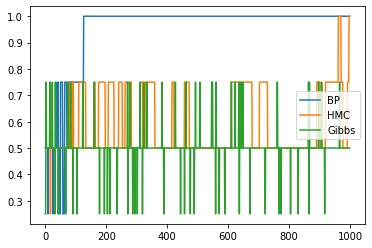

In [9]:
plt.plot(history_bp.history['accuracy'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['acc'], label = 'HMC')
plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.legend()
plt.show()

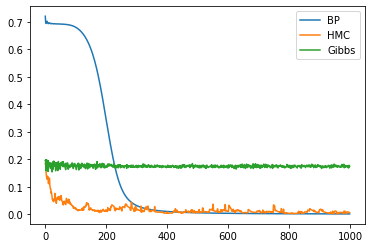

In [10]:
plt.plot(history_bp.history['loss'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['loss'], label = 'HMC')
plt.plot(list(range(epochs)), history_gibbs['loss'], label = 'Gibbs')
plt.legend()
plt.show()

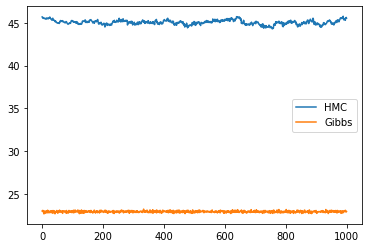

In [11]:
plt.plot(list(range(1000)), tlp_burnin_hmc, label = 'HMC')
plt.plot(list(range(1000)), tlp_burnin_gibbs, label = 'Gibbs')
plt.legend()
plt.show()